In [1]:
import numpy as np
import pandas as pd
import os
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [2]:
def get_images(file_path):
    image_names = os.listdir(file_path)
    img_g,img_m = [],[]
    for imgs in image_names:
        img = cv2.imread(file_path+imgs)
        img = cv2.normalize(img,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img = img[:,:,::-1]
        img_g.append(img[:,:256])
        img_m.append(np.reshape(img[:,256:],(256*256*3)))
        del img
    del image_names
    return img_g,img_m

In [3]:
def base_convolution_module(input_layer):
    # base covolution module to get input image feature maps 
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

In [4]:
def last_conv_module(input_layer):
    layer = pyramid_pooling_module(input_layer)
    layer = Convolution2D(filters=3,kernel_size=3,padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('sigmoid')(layer)
    layer = tf.keras.layers.Flatten()(layer)
    return layer

In [5]:
def pyramid_pooling_module(input_layer):
    # pyramid pooling module
    base = base_convolution_module(input_layer)
    # red
    red = GlobalAveragePooling2D()(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1))(red)
    red = UpSampling2D(size=256,interpolation='bilinear')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2))(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1))(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4))(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1))(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8))(base)
    green = Convolution2D(filters=64,kernel_size=(1,1))(green)
    green = UpSampling2D(size=8,interpolation='bilinear')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

In [6]:
def conv_block(layer,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    f1,f2,f3 = filters
    layer_skip = layer
    # block_a
    layer = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal')(layer)
    layer = BatchNormalization()(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    # block_b
    layer = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal')(layer)
    layer = BatchNormalization()(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    # block_c
    layer = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal')(layer)
    layer = BatchNormalization()(layer)
    # skip_conv
    layer_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same')(layer_skip)
    layer_skip = BatchNormalization()(layer_skip)
    # block_c + skip_conv
    layer = Add()([layer,layer_skip])
    layer = ReLU()(layer)
    return layer

In [7]:
train_folder="cityscapes_data/cityscapes_data/train/"
valid_folder="cityscapes_data/cityscapes_data/val/"

In [8]:
train_imgs,train_masks=get_images(train_folder)
# print(train_imgs.shape,train_masks.shape)

In [9]:
valid_imgs,valid_masks=get_images(valid_folder)
# print(valid_imgs.shape,valid_masks.shape)

In [10]:
input_layer = tf.keras.Input(shape=np.squeeze(train_imgs[0]).shape,name='input')

# print(input_layer)

output_layer = last_conv_module(input_layer)

# print(output_layer)

model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 128         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='mse')
model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
          epochs=30,steps_per_epoch=297,verbose=1,batch_size=1)
tf.keras.models.save_model(model,'best_model.h5')

Train on 2975 samples, validate on 500 samples
Epoch 1/30
 297/2975 [=>............................] - ETA: 12:59 - loss: 0.0218 - val_loss: 0.0000e+00

In [27]:
model.load_weights('best_model.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='mse')
model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
          epochs=30,steps_per_epoch=297,verbose=1,batch_size=1)
tf.keras.models.save_model(model,'best_model.h5')

Train on 2975 samples, validate on 500 samples
Epoch 1/30
 297/2975 [=>............................] - ETA: 13:02 - loss: 0.0188 - val_loss: 0.0000e+00

In [65]:
model.load_weights('best_model.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='mse')
model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
          epochs=30,steps_per_epoch=297,verbose=1,batch_size=1)
tf.keras.models.save_model(model,'best_model.h5')

Train on 2975 samples, validate on 500 samples
Epoch 1/30
 297/2975 [=>............................] - ETA: 13:12 - loss: 0.0168 - val_loss: 0.0000e+00

In [84]:
model.load_weights('best_model.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='mse')
model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
          epochs=30,steps_per_epoch=297,verbose=1,batch_size=1)
tf.keras.models.save_model(model,'best_model.h5')

Train on 2975 samples, validate on 500 samples
Epoch 1/30
 297/2975 [=>............................] - ETA: 12:51 - loss: 0.0162 - val_loss: 0.0000e+00

In [164]:
model.load_weights('resnet_model.h5')
def plot(img,mask,pred):
    mask = np.reshape(mask,(256,256,3))
    pred = np.reshape(pred,(256,256,3))
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask)
    ax2.axis('off')
    ax3.imshow(pred)
    ax3.axis('off')

In [165]:
predictions = model.predict(np.array(valid_imgs,dtype='float16'),batch_size=1)

In [166]:
#https://www.jeremyjordan.me/evaluating-image-segmentation-models/
iou_score = []
# print(valid_masks[0].shape)
# print(pred_masks[0].shape)
for i in range(500):
    mask = np.reshape(valid_masks[i],(256,256,3))
    pred = np.reshape(predictions[i],(256,256,3))
    intersection = np.logical_and(pred, mask)
    union = np.logical_or(pred, mask)
    iou_score.append(np.sum(intersection) / np.sum(union))
# print(iou_score)
print(np.average(iou_score))

0.9190443630706806


In [167]:
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy')
# train_imgs = np.array(train_imgs,dtype='float16')
# train_masks = np.array(train_imgs,dtype='float16')
# valid_imgs = np.array(valid_imgs,dtype='float16')
# valid_masks = np.array(valid_masks,dtype='float16')

# print(train_imgs.shape)
# print(train_masks.shape)
# print(valid_imgs.shape)
# print(valid_masks.shape)

# model.fit(train_imgs,train_masks,
#           validation_data=(valid_imgs,valid_masks),
#           epochs=40,steps_per_epoch=2975,verbose=1,batch_size=1)

-------------Input---------------Actual mask--------------Predicted mask-------
plotted


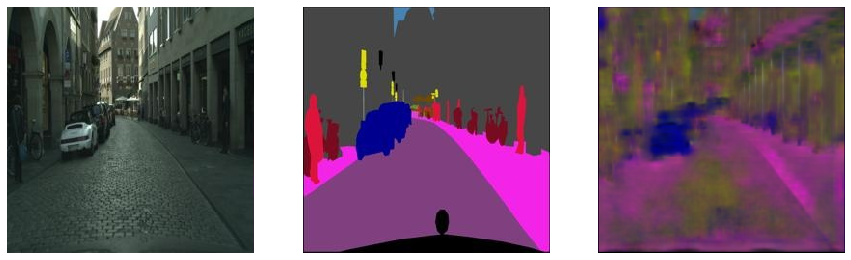

In [168]:
print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(1):
    x = np.random.randint(0,500,size=1)[0]
    plot(valid_imgs[x],valid_masks[x],predictions[x])
    print("plotted")

-------------Input---------------Actual mask--------------Predicted mask-------
plotted


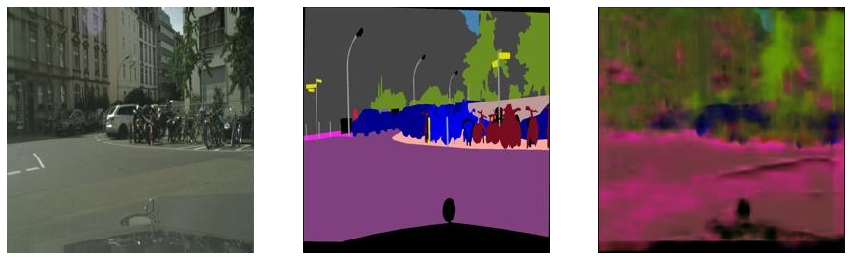

In [184]:
print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(1):
    x = np.random.randint(0,500,size=1)[0]
    plot(valid_imgs[x],valid_masks[x],predictions[x])
    print("plotted")

-------------Input---------------Actual mask--------------Predicted mask-------
plotted


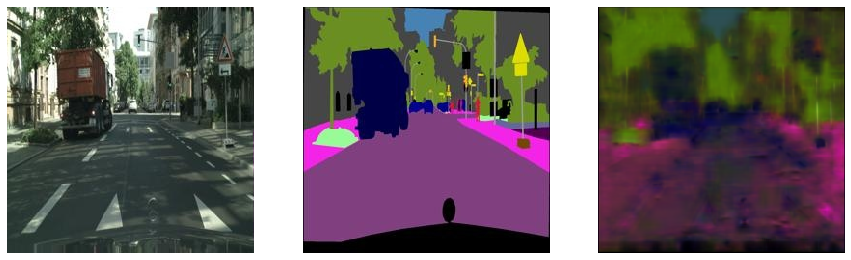

In [173]:
print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(1):
    x = np.random.randint(0,500,size=1)[0]
    plot(valid_imgs[x],valid_masks[x],predictions[x])
    print("plotted")